# PreProcessing Demonstration

In this notebook, we will explore the PyTorch Dataset class and show how it can be used to handle input images. It should do some light preprocessing to make sure everything is available. 

Some things to note:
* checks to see that there is a 1-to-1 correspondence between the datasets
* does the tiling
* exports tiles that are extra

In [1]:
# Helpful trick for loading the directories correction
import sys, os
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))


from src.data.worldfloods.dataset import WorldFloodsDataset

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Load Demo Image

For this demonstration, we need a S2 AND a groundtruth image. We have two that we can download.

In [12]:
from src.data.worldfloods.dataset import WorldFloodsImage
from src.data.worldfloods.download import download_image, get_image_path
from src.data.utils import download_data_from_bucket
from pathlib import Path

gs_index = "gs://"
bucket_id = "ml4floods"
path = "worldfloods/public/"
sub_dir = "train/S2"
file_name = "01042016_Holmes_Creek_at_Vernon_FL.tif"


# ============
# DATAIMAGE
# ============
file_name = "ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif"
dc_image_example = WorldFloodsImage(filename=file_name)
print(dc_image_example)

# download image from bucket
destination_dir = Path(root).joinpath("datasets/trials/image/S2")
download_image(dc_image_example, destination_dir)


# ============
# GROUND TRUTH IMAGE
# ============
file_name = "ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif"

dc_gt_example = WorldFloodsImage(filename=file_name)
print(dc_gt_example)

# download image from bucket
destination_dir = Path(root).joinpath("datasets/trials/image/gt")
download_image(dc_gt_example, destination_dir)



WorldFloodsImage(filename='ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif', uri=None, filepath=None, bucket_id=None, product_id=None, load_date=datetime.datetime(2021, 2, 18, 9, 37, 11, 400721), source_system='Not Specified')
Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2' Is Already There.
WorldFloodsImage(filename='ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif', uri=None, filepath=None, bucket_id=None, product_id=None, load_date=datetime.datetime(2021, 2, 18, 9, 37, 11, 400721), source_system='Not Specified')
Folder '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt' Is Already There.


In [3]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2

01042016_Holmes_Creek_at_Vernon_FL.tif


## Outline the Immediate Steps

* check for file correspondence between the directories

## Initialize PyTorch Dataset

In [4]:
import os
import random
from pathlib import Path
from typing import Callable, List, Optional, Tuple

import numpy as np
import rasterio
import rasterio.windows
from torch.utils.data import Dataset

from src.data.utils import check_path_exists
from src.data.worldfloods.configs import CHANNELS_CONFIGURATIONS
from src.data.worldfloods.prepare_data import prepare_data_func


from dataclasses import dataclass, field
from datetime import datetime
from typing import List, Dict



class WorldFloodsDataset(Dataset):
    """
    A dataloader for the WorldFloods dataset.

    Attributes
    ----------
    window_size: tuple(int, int)
            size of the tiling window
    image_prefix: str
            the subdirectory name for the images
    gt_prefix: str
            the subdirectory name for the groundtruth
    transform: Callable
            NOT SURE WHAT THIS IS FOR (MAYBE IMAGE TRANSFORMS)
    sample: bool
            NOT SURE WHAT THIS IS FOR
    last_filename: str
            name of the file name that was pulled last
    yield_smaller_patches: bool
            flag to indicate whether to ignore the smaller tiles
            at the end of the image after tiling
    s2_channels: str
            the channels to choose from the original image
    dataset_dirs: str
            root directory containing all the data
    filepaths: List[str]
            the directory for the images and groundtruths
    slices: List[slice]
            list of slices to extract tiles from the original image

    """

    def __init__(
        self,
        image_files: List[str],
        window_size: Tuple[int, int] = (128, 128),
        image_prefix: str = "/images/",
        gt_prefix: str = "/gt/",
        image_suffix: str = "tiff",
        transform: Callable = None,
        limit=None,
        sample: bool = False,
        yield_smaller_patches: bool = False,
        use_channels: List[str] = "all",
    ):

        self.image_files = image_files
        self.window_size = window_size
        self.image_prefix = image_prefix
        self.gt_prefix = gt_prefix
        self.image_suffix = image_suffix
        self.transform = transform
        self.limit = limit
        self.sample = sample
        self.last_filename = None
        self.yield_smaller_patches = yield_smaller_patches

        self.s2_channels = CHANNELS_CONFIGURATIONS[use_channels]


        # sort to make sure that the order is deterministic
        # (order of the flow of data points to the ML model)
        # TODO: Do this for the list of filepaths at the end as well
        self.image_files.sort()




In [5]:
image_files = ["/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/S2/01042016_Holmes_Creek_at_Vernon_FL.tif"]

train_dataset = WorldFloodsDataset(
    image_files=image_files,
)

## Tiling

First, we can access the rasterio dataset and get access to some of the attributes. The most important one for now is the `height` and `width`.

**Source**: [StackOverFlow](https://gis.stackexchange.com/questions/285499/how-to-split-multiband-image-into-image-tiles-using-rasterio)

In [16]:
with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    print(dataset)
    print(type(dataset))
    print(f"Height: {dataset.meta['height']}")
    print(f"Width: {dataset.meta['width']}")

<open DatasetReader name='gs://ml4floods/worldfloods/public/train/gt/01042016_Holmes_Creek_at_Vernon_FL.tif' mode='r'>
<class 'rasterio.io.DatasetReader'>
Height: 1980
Width: 2841


In [68]:
from rasterio.io import DatasetReader
from itertools import product
from rasterio import windows
import rasterio


def get_tiles(
    ds: rasterio.io.DatasetReader, height: int = 128, width: int = 123
) -> rasterio.windows.Window:
    """a generator for rasterio specific slices given a rasterio dataset

    Args:
        ds (rasterio.io.DatasetReader): a rasterio dataset object
        height (int): the height for the slice
        width (int): the width for the slice

    Yields:
        window (rasterio.windows.Window): slicing
    """
    # extract the row height from the dataset
    n_columns, n_rows = ds.meta["width"], ds.meta["height"]

    # create the offsets
    offsets = product(range(0, n_columns, width), range(0, n_rows, height))

    for col_offset, row_offset in offsets:
        window = windows.Window(
            col_off=col_offset,
            row_off=row_offset,
            width=width,
            height=height,
        )
        yield window


### Quick Demo

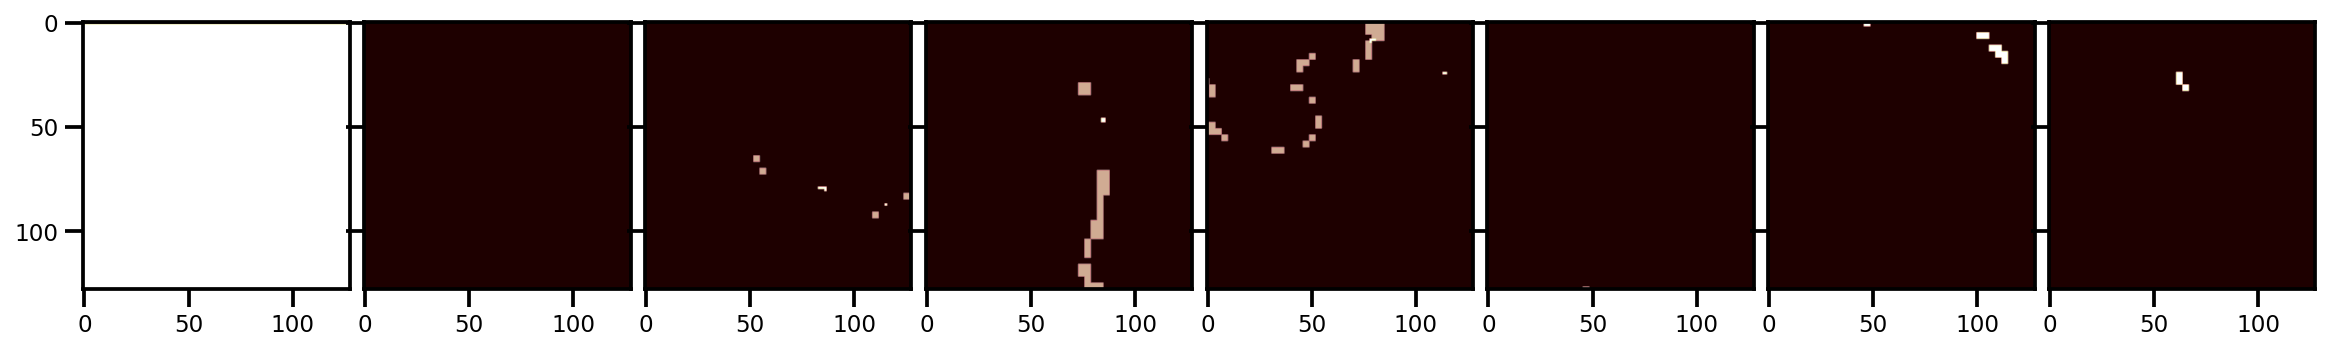

In [69]:
from rasterio.plot import show as rasterio_show
from mpl_toolkits.axes_grid1 import ImageGrid

n_tiles = 8
iteration = 0

fig = plt.figure(figsize=(20., 30.))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(1, n_tiles),
    axes_pad=0.1,
)

with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    
    for iax, window in zip(grid, get_tiles(dataset, 128, 128)):
        
        # open the dataset with only the window selected
        sub_image = dataset.read(1, window=window)
        
        # display demo image
        rasterio_show(sub_image, ax=iax, cmap="pink")
    
        iteration += 1
        
        # stop the iteration once we've reached the classes
        if iteration == n_tiles:
            break
        

#### ML Modification (Equal Tiling)

In [32]:
n_tiles = 16
iteration = 0

with rasterio.open("gs://"+get_image_path(dc_example)) as dataset:
    
    for window in get_tiles(dataset, 128, 128):
        
        
        # open the dataset with only the window selected
        sub_image = dataset.read(1, window=window)
        
        if sub_image.shape != (128, 128):
            print("Ooops, image is not the correct size! Moving on...")
            continue
    
        iteration += 1
        print("Continue:", sub_image.shape, iteration, n_tiles)
        
        # stop the iteration once we've reached the classes
        if iteration == n_tiles:
            print('Reached # of iterations...Stopping')
            break
        
        

Continue: (128, 128) 1 16
Continue: (128, 128) 2 16
Continue: (128, 128) 3 16
Continue: (128, 128) 4 16
Continue: (128, 128) 5 16
Continue: (128, 128) 6 16
Continue: (128, 128) 7 16
Continue: (128, 128) 8 16
Continue: (128, 128) 9 16
Continue: (128, 128) 10 16
Continue: (128, 128) 11 16
Continue: (128, 128) 12 16
Continue: (128, 128) 13 16
Continue: (128, 128) 14 16
Continue: (128, 128) 15 16
Ooops, image is not the correct size! Moving on...
Continue: (128, 128) 16 16
Reached # of iterations...Stopping


In [15]:
window.height, window.width

(128, 128)

In [ ]:
            
def get_equal_tiles(ds: DatasetReader, height: int=128, width: int=123) -> np.ndarray:
    
    for window in get_tiles(ds=ds, height=height, width=width):
        if (window.height, window.width) == (height, width):
            yield window
        else:
            continue

### Saving the Tiles

##### IMAGES

In [106]:
!rm -rf /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/
!mkdir /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/

01042016_Holmes_Creek_at_Vernon_FL.tif	S2  gt	gt_tiles  tiles
01042016_Holmes_Creek_at_Vernon_FL.tif	S2  gt	gt_tiles  image_tiles  tiles


In [107]:
# output directory
output_tile_dir = "/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/"
file_name = "01042016_Holmes_Creek_at_Vernon_FL"

n_tiles = 16
itile = 0
with rasterio.open("gs://"+get_image_path(dc_image_example)) as dataset:
    
    # copy the metadata
    window_meta = dataset.meta.copy()
    
    # loop through tiling generator
    for window in get_tiles(dataset, 128, 128):
        
        # copy the meta data
        window_meta["width"] = window.width
        window_meta["height"] = window.height
        
        # check for shape is the same as window_size we want!
        if dataset.read(1, window=window).shape != (128, 128):
            print("Ooops, image is not the correct size! Moving on...")
            continue
        else:
            # create unique filename for the window
            window_file_name = f"{file_name}_tile_{itile}.tif"
            
            # filepath for saving
            output_tile_file_name = str(Path(output_tile_dir).joinpath(window_file_name))
            
            # open file and also save meta data
            with rasterio.open(output_tile_file_name, "w", **window_meta) as out_f:
                out_f.write(dataset.read(window=window))
            
        
        itile += 1
        
        # stop the iteration once we've reached the classes
        if itile == n_tiles:
            print('Reached # of iterations...Stopping')
            break

Ooops, image is not the correct size! Moving on...
Reached # of iterations...Stopping


In [108]:
!rm -rf /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/
!mkdir /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles/
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/

01042016_Holmes_Creek_at_Vernon_FL.tif	S2  gt	image_tiles  tiles
01042016_Holmes_Creek_at_Vernon_FL.tif	S2  gt	gt_tiles  image_tiles  tiles


In [109]:
# output directory
output_tile_dir = "/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles/"
file_name = "01042016_Holmes_Creek_at_Vernon_FL"

n_tiles = 16
itile = 0
with rasterio.open("gs://"+get_image_path(dc_gt_example)) as dataset:
    
    # copy the metadata
    window_meta = dataset.meta.copy()
    
    # loop through tiling generator
    for window in get_tiles(dataset, 128, 128):
        
        # copy the meta data
        window_meta["width"] = window.width
        window_meta["height"] = window.height
        
        # check for shape is the same as window_size we want!
        if dataset.read(1, window=window).shape != (128, 128):
            print("Ooops, image is not the correct size! Moving on...")
            continue
        else:
            # create unique filename for the window
            window_file_name = f"{file_name}_tile_{itile}.tif"
            
            # filepath for saving
            output_tile_file_name = str(Path(output_tile_dir).joinpath(window_file_name))
            
            # open file and also save meta data
            with rasterio.open(output_tile_file_name, "w", **window_meta) as out_f:
                out_f.write(dataset.read(window=window))
            
        
        itile += 1
        
        # stop the iteration once we've reached the classes
        if itile == n_tiles:
            print('Reached # of iterations...Stopping')
            break

Ooops, image is not the correct size! Moving on...
Reached # of iterations...Stopping


In [110]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles/

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_10.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_11.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_12.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_13.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_14.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_15.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_2.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_3.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_4.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_5.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_6.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_7.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_8.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_9.tif


### Potential Improvements

So this can be very slow if we need to call this many times. Generators are nice as they do save on memory, however, I can see this being slow if we want to use this to do many calls. 

---
#### 1 - Concurrent Processing

This will allow us to read and write concurrently. It will be a much faster method.

**Source**: [Rasterio Docs](https://rasterio.readthedocs.io/en/latest/topics/concurrency.html)

---
#### 2 - Better Naming Convention

All I did was create a simple naming scheme via some order. But it would be nice to have that already done.

---

#### 3 - ML-Style saving

For ML tasks, it is necessary

---
#### 4 - Transformations

When we grab the tiles, we may want to do some sort of transformation. That will require more work for the application. But that transformation should be embedded within the actual tile extraction. 

## ML Loading Demo

#### All files in directory

In [99]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/images/gt_tiles/

ls: cannot access '/home/jemanjohnson34/projects/ml4floods/datasets/trials/images/gt_tiles/': No such file or directory


In [119]:
directory = "/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/"
p = Path(directory).glob('*.tif')
files = [str(x) for x in p if x.is_file()]
files

['/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_14.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_8.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_3.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_5.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_15.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_6.tif',
 '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_12.tif',
 '/ho

In [123]:
image_prefix = "image_tiles"
gt_prefix = "gt_tiles"
files[0].replace(image_prefix, gt_prefix, 1)

'/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles/01042016_Holmes_Creek_at_Vernon_FL_tile_14.tif'

In [116]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_10.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_11.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_12.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_13.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_14.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_15.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_2.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_3.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_4.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_5.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_6.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_7.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_8.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_9.tif


In [117]:
!ls /home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles

01042016_Holmes_Creek_at_Vernon_FL_tile_0.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_1.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_10.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_11.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_12.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_13.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_14.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_15.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_2.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_3.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_4.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_5.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_6.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_7.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_8.tif
01042016_Holmes_Creek_at_Vernon_FL_tile_9.tif


In [115]:
# get groundtruth directory
path_dir = Path("/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles")
image_parent = path_dir.parent
print(image_parent)
t = path_dir.replace(image_parent.parent / "image/gt_tiles")
print(t)

/home/jemanjohnson34/projects/ml4floods/datasets/trials/image


OSError: [Errno 39] Directory not empty: '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/image_tiles' -> '/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/gt_tiles'

In [ ]:
directory = "/home/jemanjohnson34/projects/ml4floods/datasets/trials/image/"
image_prefix = ""
all_file_names = Path()

In [143]:
class WorldFloodsDataset(Dataset):
    """
    A dataloader for the WorldFloods dataset.

    Attributes
    ----------
    window_size: tuple(int, int)
            size of the tiling window
    image_prefix: str
            the subdirectory name for the images
    gt_prefix: str
            the subdirectory name for the groundtruth
    transform: Callable
            NOT SURE WHAT THIS IS FOR (MAYBE IMAGE TRANSFORMS)
    sample: bool
            NOT SURE WHAT THIS IS FOR
    last_filename: str
            name of the file name that was pulled last
    yield_smaller_patches: bool
            flag to indicate whether to ignore the smaller tiles
            at the end of the image after tiling
    s2_channels: str
            the channels to choose from the original image
    dataset_dirs: str
            root directory containing all the data
    filepaths: List[str]
            the directory for the images and groundtruths
    slices: List[slice]
            list of slices to extract tiles from the original image

    """

    def __init__(
        self,
        image_files: List[str],
        image_prefix: str = "/image_files/",
        gt_prefix: str = "/gt_files/",
    ):

        self.image_files = image_files
        self.image_prefix = image_prefix
        self.gt_prefix = gt_prefix


        # sort to make sure that the order is deterministic
        # (order of the flow of data points to the ML model)
        # TODO: Do this for the list of filepaths at the end as well
        self.image_files.sort()

    def __getitem__(self, idx):
        
        # get filenames
        x_name = self.image_files[idx]
        y_name = x_name.replace(self.image_prefix, gt_prefix, 1)
        
        # Open Image File
        with rasterio.open(x_name) as f:
            x_tif = f.read(1)
            
        # Open Ground Truth File
        with rasterio.open(y_name) as f:
            y_tif = f.read(1)
        
        # get the channels
        return x_tif, y_tif

In [148]:
def get_files_in_directory(directory: str, suffix: str) -> List[str]:
    p = Path(directory).glob(f'*{suffix}')
    files = [str(x) for x in p if x.is_file()]
    return files

def get_filenames_in_directory(directory: str, suffix: str) -> List[str]:
    p = Path(directory).glob(f'*{suffix}')
    files = [str(x.name) for x in p if x.is_file()]
    return files

In [145]:
image_prefix = "image_tiles"
gt_prefix = "gt_tiles"
pt_ds = WorldFloodsDataset(files, image_prefix, gt_prefix)

In [146]:
x, y = pt_ds[10]

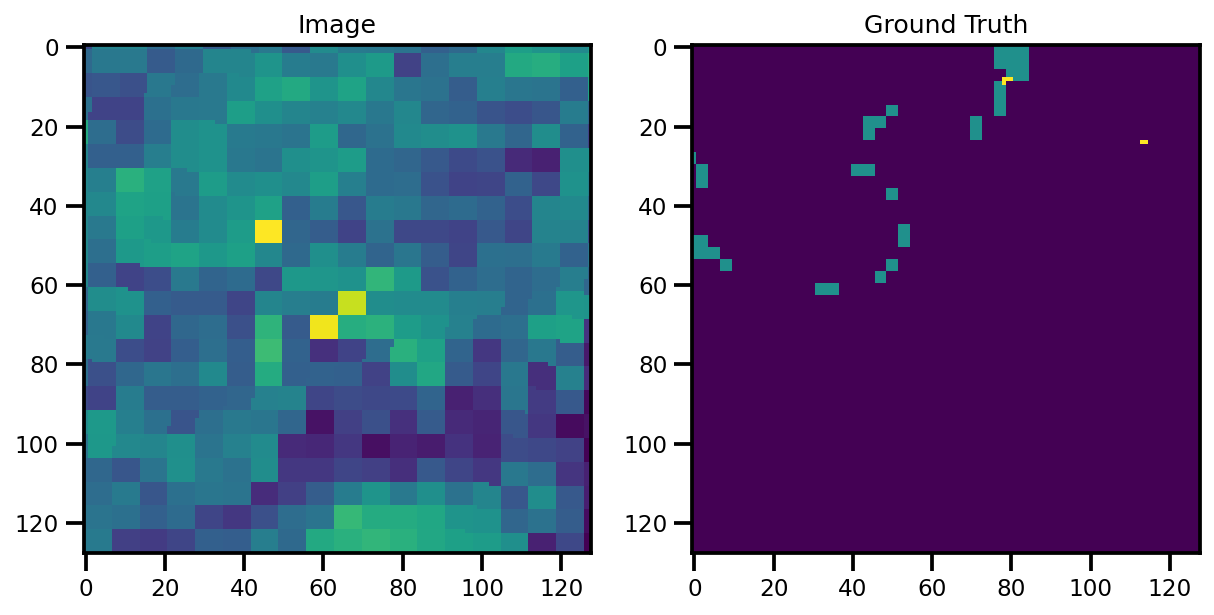

In [147]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2)

ax[0].imshow(x)
ax[0].set_title("Image")

ax[1].imshow(y)
ax[1].set_title("Ground Truth")

plt.show()

In [ ]:
#         self.filepaths = prepare_data_func(self)
#         self.slices = None

#         if (self.window_size is not None) and not self.sample:
#             self._include_all(yield_smaller_patches)
#             if limit is not None:
#                 vals = np.random.choice(
#                     a=len(self.filepaths), size=limit, replace=False
#                 )
#                 self.filepaths = [self.filepaths[idx_v] for idx_v in vals]
#                 self.slices = [self.slices[idx_v] for idx_v in vals]

#     def _include_all(self, yield_smaller_patches=False):
#         """
#         Replace the original filepaths with the tiled filenames and
#         slice indices of the tiled images.

#         :param      yield_smaller_patches:  flag to indicate whether to ignore
#                                                                                 the smaller tiles at the end of the
#                                                                                 image after tiling
#         :type       yield_smaller_patches:  boolean
#         """

#         tiled_filenames = []
#         slices = []

#         for filepath in self.filepaths:
#             orig_image_shape = rasterio.open(filepath).shape

#             # list of x,y coordinate positions for the tiles
#             tile_start_coord_x = np.arange(0, orig_image_shape[0], self.window_size[0])
#             tile_start_coord_y = np.arange(0, orig_image_shape[1], self.window_size[1])

#             # tiling the entire image by storing the filepath and slices of individual tiles
#             for r in tile_start_coord_x:
#                 for c in tile_start_coord_y:
#                     slice_ = (
#                         slice(r, min(r + self.window_size[0], orig_image_shape[0])),
#                         slice(c, min(c + self.window_size[1], orig_image_shape[1])),
#                     )

#                     shape_slice = tuple([s.stop - s.start for s in slice_])

#                     # ignore the tiles that are smaller than the specified window_size
#                     # if shape_slice != self.window_size and not yield_smaller_patches:
#                     # TODO: check the logic of this negation
#                     if shape_slice != self.window_size and yield_smaller_patches:
#                         continue

#                     tiled_filenames.append(filepath)
#                     slices.append(slice_)

#         # updating the attributes after tiling
#         self.filepaths = tiled_filenames
#         self.slices = slices

#     def __getitem__(self, idx):
#         """
#         Extract items using index values

#         :param      idx:                The index
#         :type       idx:                int

#         :returns:   image and the ground truth
#         :rtype:     tuple(ndarray, ndarray)
#         """
#         x_name = self.filepaths[idx]

#         self.last_filename = self.filepaths[idx]

#         x_tif = rasterio.open(x_name)

#         # define the window size from the tile slice
#         # default window size is the same as the original image size.
#         if self.window_size is None:
#             window = rasterio.windows.Window.from_slices(
#                 slice(0, x_tif.shape[0]), slice(0, x_tif.shape[1])
#             )
#         else:
#             slice_ = self.slices[idx]
#             window = rasterio.windows.Window.from_slices(*slice_)

#         # Read input as the selected channels from the original image
#         channels_1_index_base_rasterio = [s + 1 for s in self.s2_channels]
#         x = x_tif.read(channels_1_index_base_rasterio, window=window)

#         # get rid of nan, convert to float
#         x = np.nan_to_num(x).astype(np.float32)

#         # Read from GT mask
#         y_name = x_name.replace(self.image_prefix, self.gt_prefix, 1)
#         y_tif = rasterio.open(y_name)
#         if x_tif.bounds != y_tif.bounds:
#             raise RuntimeError(
#                 f"Bounds for tif files {x_name} and {y_name} do not match"
#             )

#         # gt values {0: invalid, 1: land, 2: water, 3: cloud}
#         y_gt = y_tif.read(window=window)

#         # TODO: Need to check why the 0th index.
#         y = np.nan_to_num(y_gt[0])

#         # Apply transformation
#         if self.transform is not None:
#             res = self.transform(image=x.transpose(1, 2, 0), mask=y)
#             x, y = res["image"], res["mask"]

#         return x, y